<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/train_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Found 560 images in train/Auto Rickshaws
Found 560 images in train/Bikes
Found 553 images in train/Cars
Found 560 images in train/Motorcycles
Found 560 images in train/Planes
Found 560 images in train/Ships
Found 560 images in train/Trains
Found 120 images in val/Auto Rickshaws
Found 120 images in val/Bikes
Found 118 images in val/Cars
Found 120 images in val/Motorcycles
Found 120 images in val/Planes
Found 120 images in val/Ships
Found 120 images in val/Trains
Found 120 images in test/Auto Rickshaws
Found 120 images in test/Bikes
Found 119 images in test/Cars
Found 120 images in test/Motorcycles
Found 120 images in test/Planes
Found 120 images in test/Ships
Found 120 images in test/Trains


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.595293,0.269281,0.918854,01:43


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.223083,0.191079,0.948687,00:32
1,0.143273,0.154368,0.957041,00:33
2,0.115909,0.130504,0.965394,00:32
3,0.087957,0.128115,0.972554,00:33
4,0.071748,0.127091,0.965394,00:34
5,0.047430,0.113003,0.968974,00:34
6,0.028223,0.114331,0.970167,00:34
7,0.018594,0.115779,0.977327,00:34
8,0.016201,0.112409,0.976134,00:35
9,0.014393,0.112472,0.974940,00:35


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in by

Training history saved at /content/drive/My Drive/models/fastai_model_history.pkl
FastAI model trained and saved to Google Drive successfully!


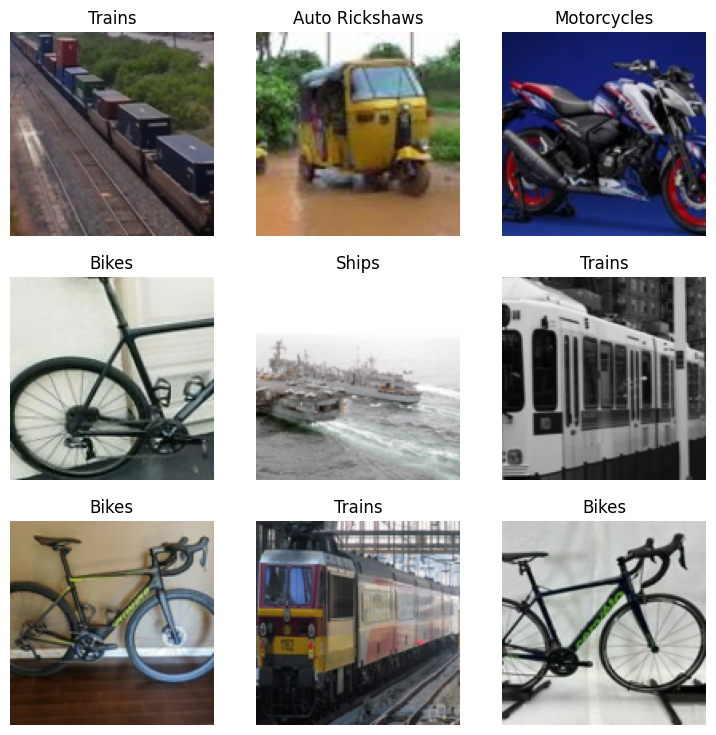

In [1]:
# Import necessary libraries
import os
import shutil
from sklearn.model_selection import train_test_split
from fastai.vision.all import *
from google.colab import drive
import pickle  # Added to save the training history

# Mount Google Drive
drive.mount('/content/drive')

# Set up directories for training data
main_dir = "/content/drive/My Drive/Vehicles"  # Adjust this to your path
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]
base_split_dir = "/content/drive/My Drive/vehicles_split"  # Adjust path for Colab

# Check if the base_split_dir exists, if not create it and split the dataset
if not os.path.exists(base_split_dir):
    split_dirs = ["train", "val", "test"]

    for split_dir in split_dirs:
        for category in categories:
            os.makedirs(os.path.join(base_split_dir, split_dir, category), exist_ok=True)
            print(f"Directory created: {os.path.join(base_split_dir, split_dir, category)}")

    # Split the data and move images to appropriate directories
    for category in categories:
        category_path = os.path.join(main_dir, category)

        # Ensure the directory exists
        if not os.path.exists(category_path):
            print(f"Directory not found: {category_path}")
            continue

        images = os.listdir(category_path)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Function to move images into respective folders
        def move_images(image_list, destination):
            for image in image_list:
                shutil.copy(os.path.join(category_path, image), os.path.join(base_split_dir, destination, category, image))

        move_images(train_images, "train")
        move_images(val_images, "val")
        move_images(test_images, "test")

    print("Data split into train, validation, and test sets successfully!")

# Check how many images were copied into each category and split
split_dirs = ["train", "val", "test"]
for split_dir in split_dirs:
    for category in categories:
        num_images = len(os.listdir(os.path.join(base_split_dir, split_dir, category)))
        print(f"Found {num_images} images in {split_dir}/{category}")

# Set up FastAI DataBlock for image classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(128))

# Load data
dls = dblock.dataloaders(base_split_dir, batch_size=32)

# Show batch of images to verify everything is correct
dls.show_batch(max_n=9)

# Create a FastAI learner using a pre-trained ResNet model
learn = vision_learner(dls, resnet18, metrics=accuracy)

# ***MODIFICATION STARTS HERE***
# Train the model and capture the history
history = learn.fine_tune(10)  # Train the model

# Save the training history (losses, accuracies, etc.)
history_data = {
    'train_loss': [loss.item() for loss in learn.recorder.losses],  # Training loss per batch
    'valid_loss': [v[0] for v in learn.recorder.values],  # Validation loss per epoch
    'accuracy': [v[1] for v in learn.recorder.values]  # Validation accuracy per epoch
}

# Save the history data
history_save_path = '/content/drive/My Drive/models/fastai_model_history.pkl'
with open(history_save_path, 'wb') as file_pi:
    pickle.dump(history_data, file_pi)

print(f"Training history saved at {history_save_path}")
# ***MODIFICATION ENDS HERE***

# Save the model to Google Drive
save_dir = '/content/drive/My Drive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

learn.export(os.path.join(save_dir, 'fastai_vehicle_model.pkl'))

print("FastAI model trained and saved to Google Drive successfully!")